In [28]:
import h5py
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from functools import reduce
from matplotlib import transforms
from functools import reduce
from skimage.util.shape import view_as_windows

In [9]:
# Read in the averaged vector field data.  

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/U_avg.h5", "r") as file: 
    U = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/V_avg.h5", "r") as file: 
    V = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/M_avg.h5", "r") as file: 
    M = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/xgrid_matrix", "r") as file: 
    xgrid = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/Headon_results/mesenchym/video1_slice4/whole_image/avg_data/ygrid_matrix", "r") as file: 
    ygrid = file["matrix"][:]

In [11]:
np.shape(U)

(185, 63, 63)

# Calculate Convergence with Pattern-Matching 

So that the convergence is not only in one point but in a region. 

In [4]:
# Generate the pattern for convergence. The grid of vectors point into middle. 
# Copied the function from orientation profile from module mesenchym_analysis.ipynb

def convergence_pattern_2D(pattern_size): 
    # Pattern size a tuple with (width, height)

    center = tuple(round(i/2) for i in pattern_size) # (c, c) tuple. 

    # construct the position matrix which has the same dimension as input matrix.
    pos_matrix_x = np.zeros(pattern_size)
    pos_matrix_y = np.zeros(pattern_size)
    # x coordinate grid matrix
    for i in range(pattern_size[0]): 
        pos_matrix_x[i, :] = np.array([i]*len(pos_matrix_x[i, :])) # The x coordinates have the same value for one row.
    # y coordinate grid matrix 
    for j in range(pattern_size[1]): 
        pos_matrix_y[:, j] = np.array([j]*len(pos_matrix_y[:, j])) # The y coordinates have the same value for one column. 

    # Construct the direction matrix U and V, which point to the center. The center coordinate substracted by other vectors.
    U_point_center = -(pos_matrix_x - center[0]) # For x coordinate direction.
    V_point_center = -(pos_matrix_y - center[1]) # For y coordinate direction. 

    # Calculate the magnitude of the point to center vector field and normalize the U and V vector field. 
    M_point_center = np.sqrt(V_point_center**2 + U_point_center**2)
    # Replace the center which has magnitude 0 with nan to avoid runtime warning. 
    M_point_center[M_point_center == 0] = np.nan
    
    V_point_center /= M_point_center
    V_point_center = np.nan_to_num(V_point_center)
    U_point_center /= M_point_center
    U_point_center = np.nan_to_num(U_point_center)
    
    return pos_matrix_x, pos_matrix_y, U_point_center, V_point_center 

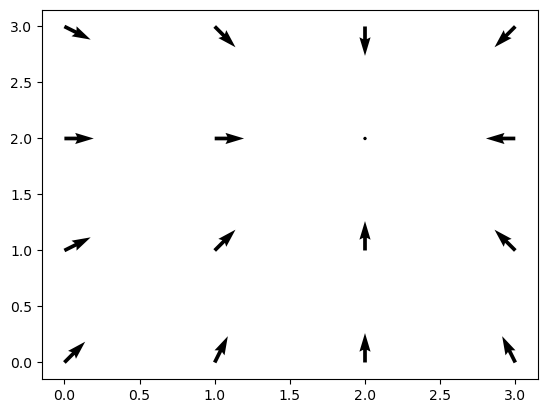

In [43]:
pos_x, pos_y, u_direc, v_direc = convergence_pattern_2D((4, 4))
plt.quiver(pos_x, pos_y, u_direc, v_direc)

In [19]:
# Normalize the whole vector field at time point t. 

def normalize_vector_field(t, U, V, M): 
    # Magnitude of the vectors. 
    M_t = M[t]
    M_t[M_t == 0] = np.nan

    U_t = U[t]
    V_t = V[t]

    U_t_nor = U_t / M_t 
    V_t_nor = V_t / M_t 

    # Turn the nan to 0.
    U_t_nor[np.isnan(U_t_nor)] = 0
    V_t_nor[np.isnan(V_t_nor)] = 0

    return U_t_nor, V_t_nor

In [57]:
def local_match_score(sub_U, sub_V, pattern_U, pattern_V): 
    # Match score is the dot product between two normalized vectors at the all same position. 
    # U and V values are both from already normalized matrices. 

    # Calculate the dot product between vectors on the same position. 
    # For 2D vectors (x1, y1) & (x2, y2) --> x1x2 + y1y2 
    orient_matrix = np.multiply(sub_U, pattern_U) + np.multiply(sub_V, pattern_V)

    return np.mean(orient_matrix) # Final match score is the mean of the orientation match in the sub region. 

# TODO: But the local region with the same positions as sub_U and sub_V should then hava the same value as the score.

In [18]:
U_nor, V_nor = normalize_vector_field(10, U, V, M)

array([0., 0., 0., 0., 0.], dtype=float32)

In [21]:
a = np.array([[1,2,3],
              [2,3,4]])
np.mean(a)

2.5

In [55]:
import numpy as np 

yourArray = np.random.randn(64,64)        # just an example
width = 2
height = 2

a = []                                    # a python list to hold the windows
match_array = np.zeros(np.shape(yourArray))

for i in range(width, yourArray.shape[0]-width+1):
    for j in range(height, yourArray.shape[1]-height+1):
        window = yourArray[i-width:i+width,j-height:j+height] # each individual window
        match_array[i-width:i+width,j-height:j+height] = i/j
        a.append(window)

In [56]:
match_array

array([[ 1.        ,  0.66666667,  0.5       , ...,  0.03225806,
         0.03225806,  0.03225806],
       [ 1.5       ,  1.        ,  0.75      , ...,  0.0483871 ,
         0.0483871 ,  0.0483871 ],
       [ 2.        ,  1.33333333,  1.        , ...,  0.06451613,
         0.06451613,  0.06451613],
       ...,
       [31.        , 20.66666667, 15.5       , ...,  1.        ,
         1.        ,  1.        ],
       [31.        , 20.66666667, 15.5       , ...,  1.        ,
         1.        ,  1.        ],
       [31.        , 20.66666667, 15.5       , ...,  1.        ,
         1.        ,  1.        ]])

In [ ]:
def global_match(t, U, V, pattern_U, pattern_V):
    